In [1]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from scipy.stats import uniform as unif_dist
from scipy.stats import norm as norm_dist
from scipy.stats import gamma as gamma_dist
from scipy.stats import beta as beta_dist

## Ejemplo Binomial con PyMC

In [5]:
def EstimacionBinomialPyMC(n=10, p=0.5, alpha=1, beta=1, densidades=[], thetas=[], i=1, q0=1, q1=1, show=0):

  # Simulación n lanzamientos de Bernoulli
  lanzamientos = np.random.binomial(1, p, size=n).tolist()

  with pm.Model() as modelo:

    # Prior para el parámetro a estimar theta: uniforme expresada como Beta
    theta = pm.Beta("theta", alpha=alpha, beta=beta)

    # Likelihood: lanzamientos observados, correspondientes a Bernoulli(theta)
    y_obs = pm.Bernoulli("y_obs", p=theta, observed=lanzamientos)

    # Inference: muestreo MC
    muestras_posterior = pm.sample(progressbar=False, return_inferencedata=True)#draws=1000, tune=100,
    axes = az.plot_trace(muestras_posterior, combined=True)
    #az.plot_posterior(muestras_posterior)
    for row in axes:
      trace_ax = row[1]
      density_ax = row[0]

      trace_ax.set_xlim(0, 1000)
      trace_ax.set_ylim(0, 1)

      density_ax.set_xlim(0, 1)

  # Estimación puntual de theta (media posterior)
  hat_theta = muestras_posterior.posterior["theta"].mean().item()
  muestreo_theta = np.array(muestras_posterior.posterior["theta"].values.flatten())

  densidades.append(muestreo_theta)
  thetas.append(hat_theta)

  muestras = np.asarray(muestreo_theta).flatten()
  a, b, loc, scale = beta_dist.fit(muestras, floc=0, fscale=1)

  return muestras_posterior, hat_theta, i+1, densidades, thetas, a, b, loc, scale

In [6]:
def EjemploBinomialPyMC(n=10, p=0.5, i_max=3, tol=0.01, leyenda=0, show=0):
    i = 0
    hat_theta = p
    densidades, thetas, params = [], [], []
    a = 1; b=1

    while i < i_max:
        ref = hat_theta
        muestras_posterior, hat_theta, i, densidades, thetas, a, b, loc, scale = EstimacionBinomialPyMC(n, p, a, b, densidades, thetas, i)

        params.append((a, b, loc, scale))
        if abs(ref - hat_theta) < tol:
            break

    if show == 1:
      theta = np.linspace(0, 1, 1000)
      fig, axs = plt.subplots(1, 2, figsize=(14, 5))

      # Cambio la posición de la leyenda a donde menos moleste
      posicion_leyenda = 'upper left' if p > 0.5 else 'upper right'

      # Panel izquierdo: distribuciones a posteriori
      for j, ((a, b, loc, scale), theta_hat) in enumerate(zip(params, thetas)):
            axs[0].plot(theta, beta_dist.pdf(theta, a, b, loc=loc, scale=scale),
                        linewidth=0.7, label=f'Itr {j+1}: E(θ)={theta_hat:.4f}')

      axs[0].set_title('Evolución de las distribuciones a posteriori')
      axs[0].set_xlabel('θ')
      axs[0].set_ylabel('Densidad')
      if leyenda==1:
        axs[0].legend(loc=posicion_leyenda)
      axs[0].grid(True)

      # Panel derecho: evolución de las estimaciones
      axs[1].scatter(range(len(thetas)), thetas, color='C0')
      axs[1].axhline(p, color='C1', linestyle='-', label=f'Valor real: {p}')
      axs[1].axhline(hat_theta, color='C1', linestyle='--', label=f'Estimación: {hat_theta:.4f}')
      axs[1].set_ylim(0, 1)
      axs[1].set_title('Convergencia de la estimación E(θ)')
      axs[1].set_xlabel('Iteración')
      axs[1].set_ylabel('Estimación E(θ)')
      axs[1].legend(loc='lower right')
      axs[1].grid(True)

      plt.tight_layout()
      plt.show()

    return muestras_posterior, hat_theta, thetas

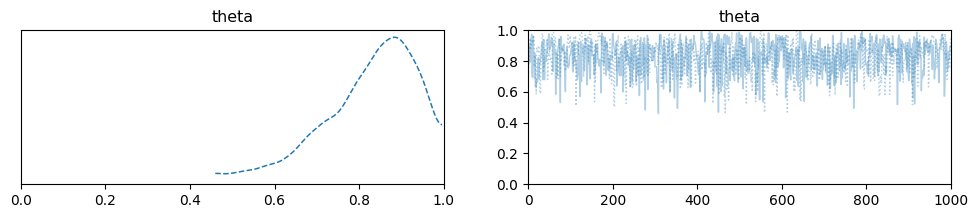

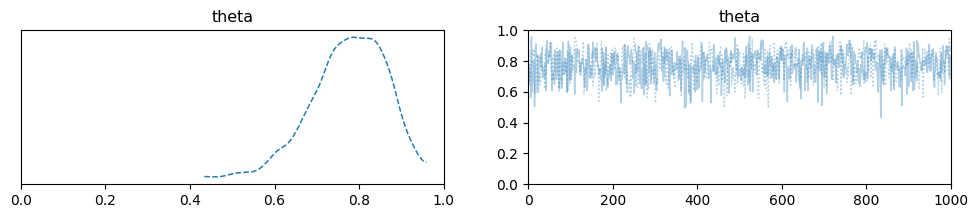

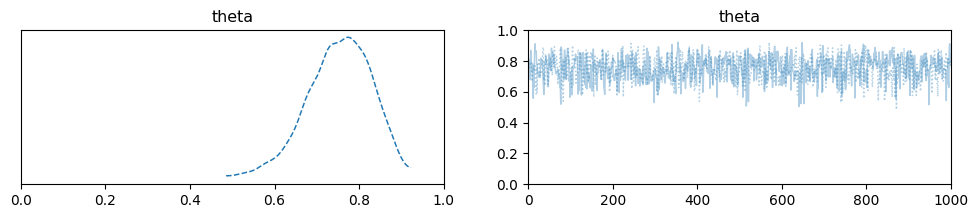

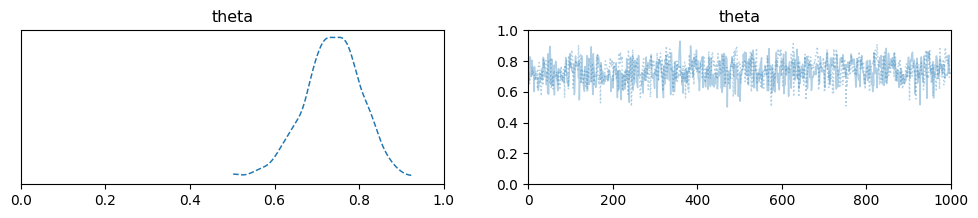

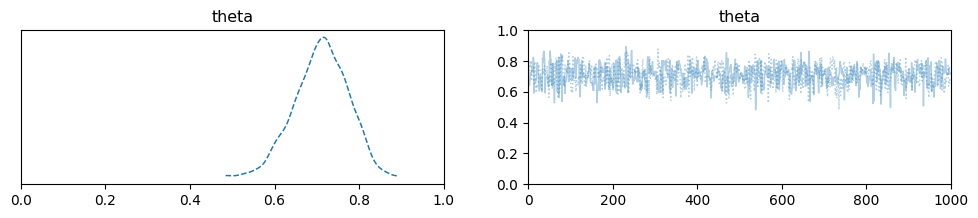

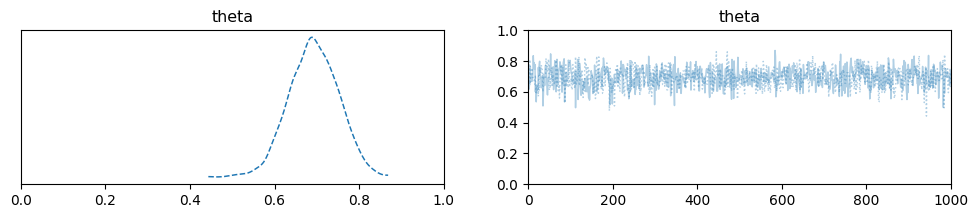

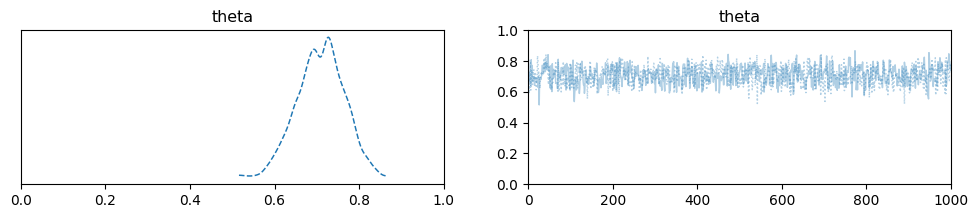

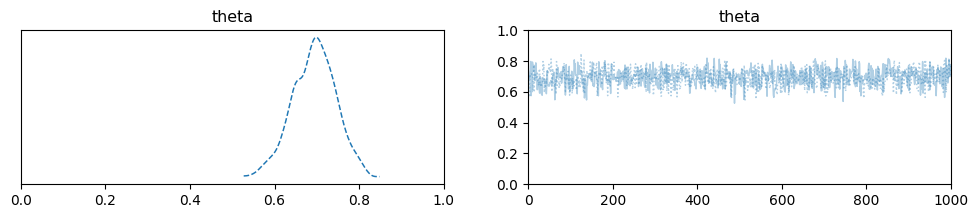

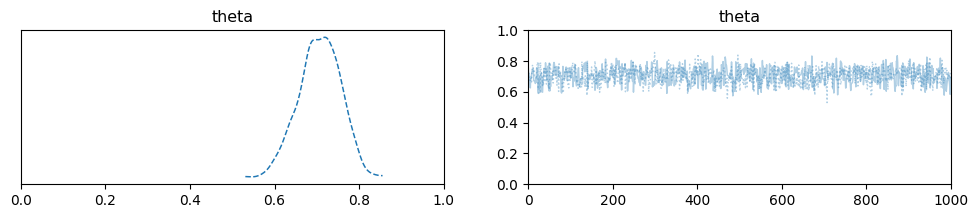

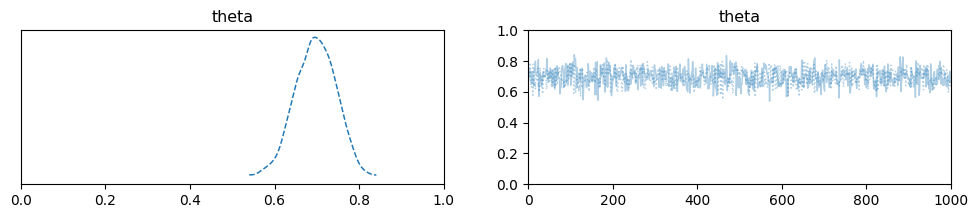

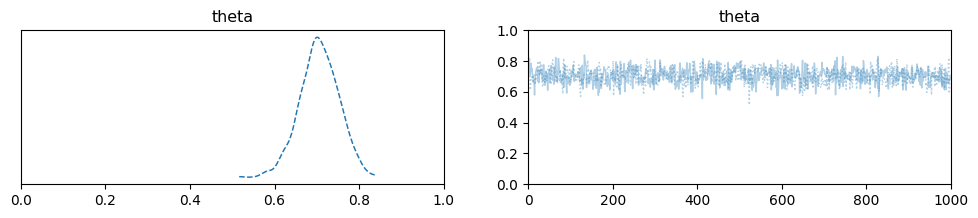

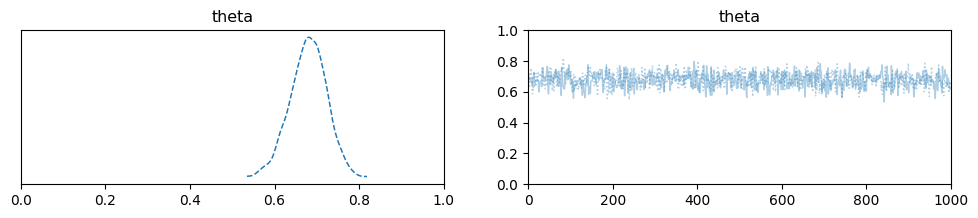

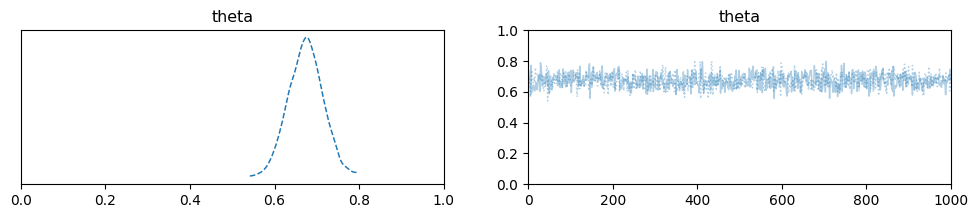

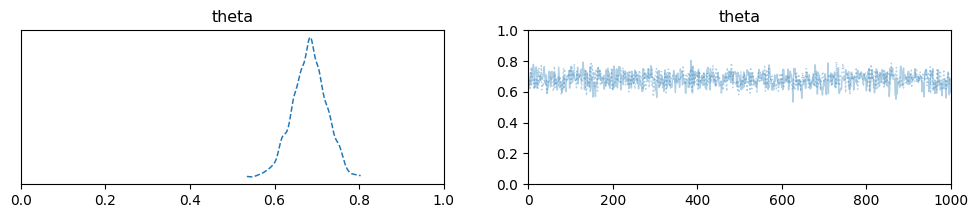

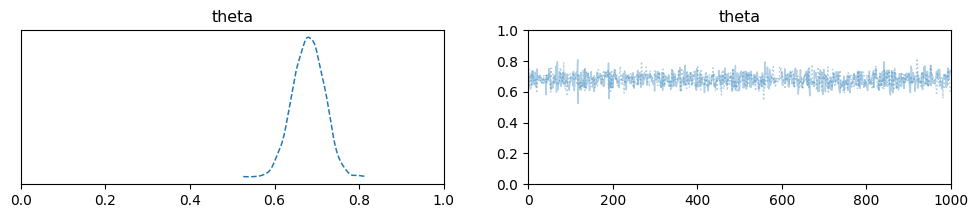

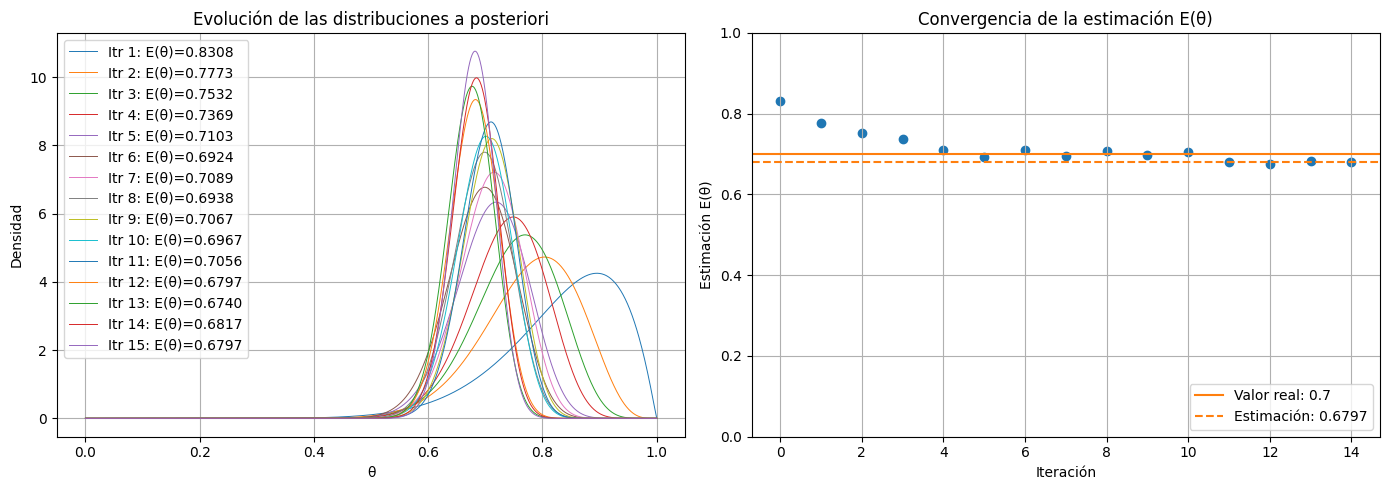

In [7]:
muestras_posterior, hat_theta, thetas = EjemploBinomialPyMC(n=10, p=0.7, i_max=15, tol=0.001, leyenda=1, show=1)